
✅ 실험별 최고 정확도(Original Accuracy) 비교 그래프:


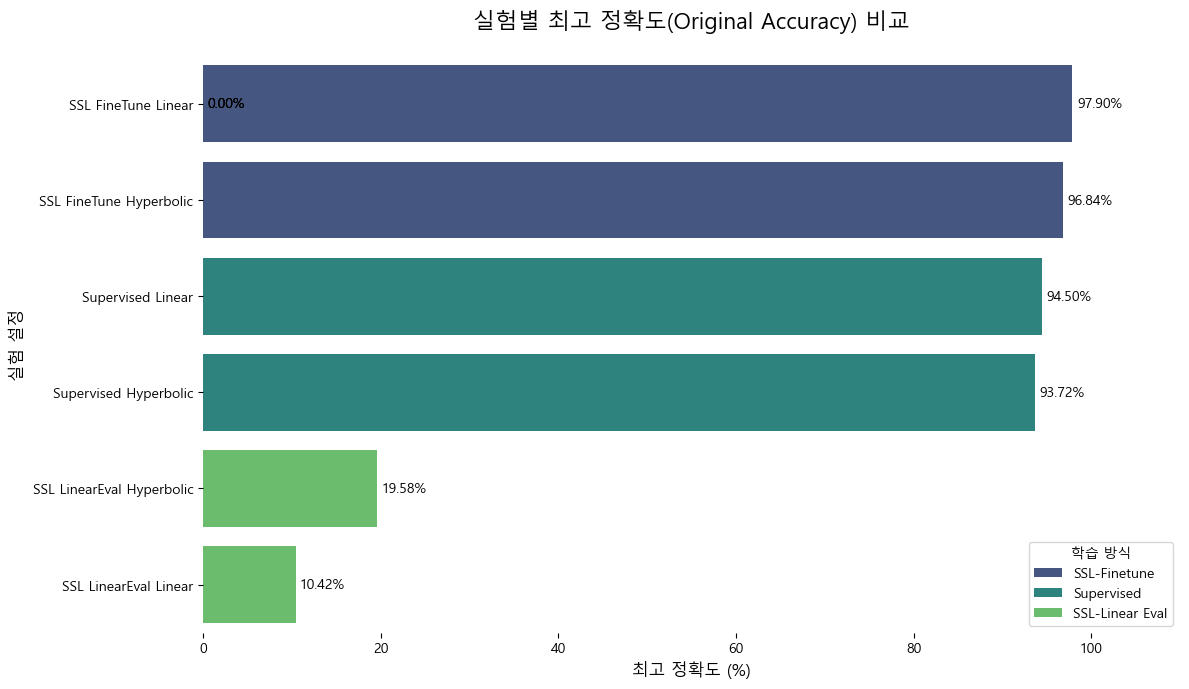


✅ 실험별 안정성(Retention) 비교 그래프:


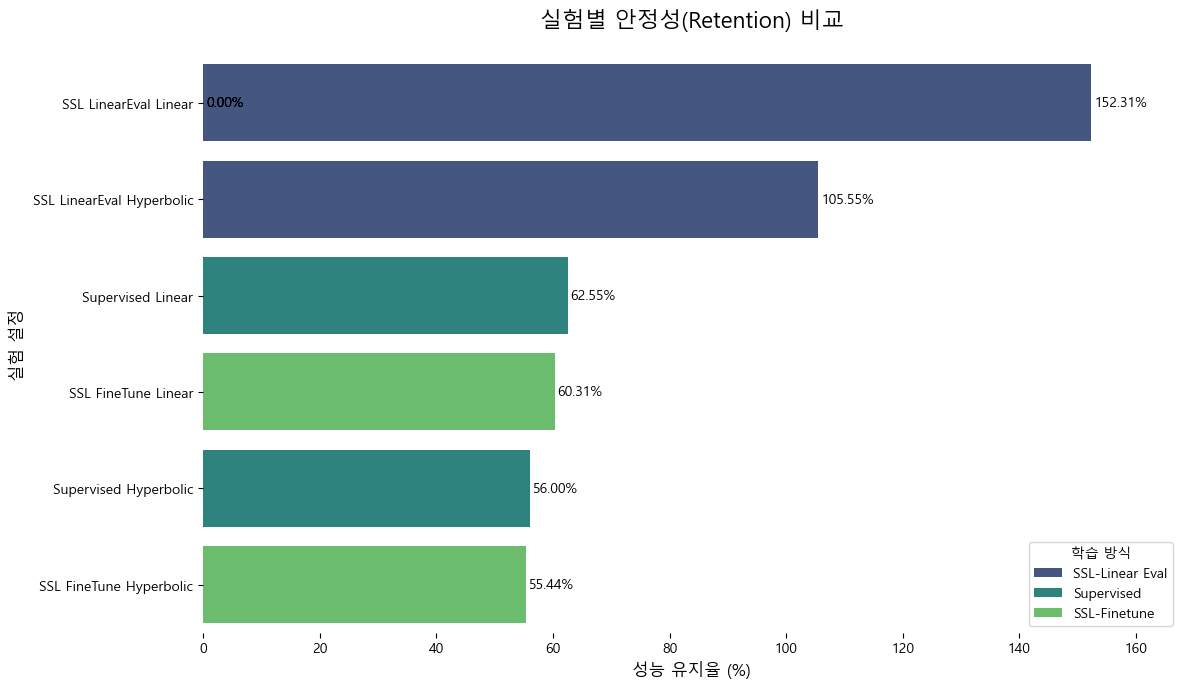


✅ 실험별 F1 Score 비교 (원본 데이터셋) 그래프:


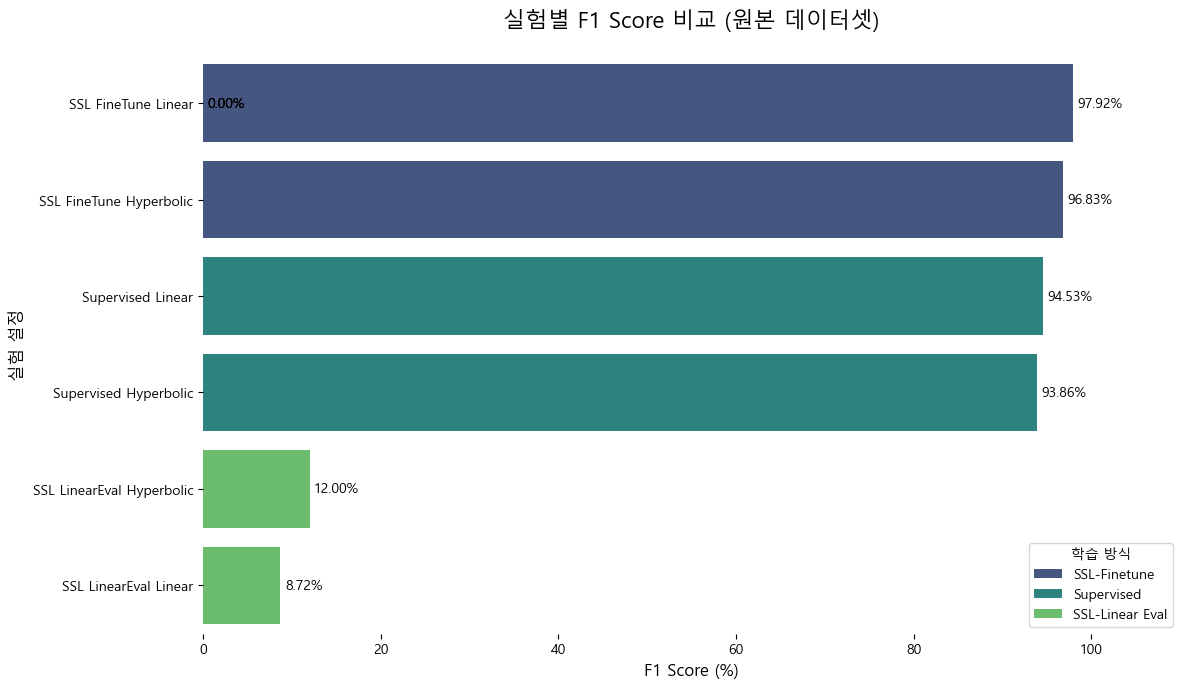


✅ 성능-안정성 관계도 그래프:


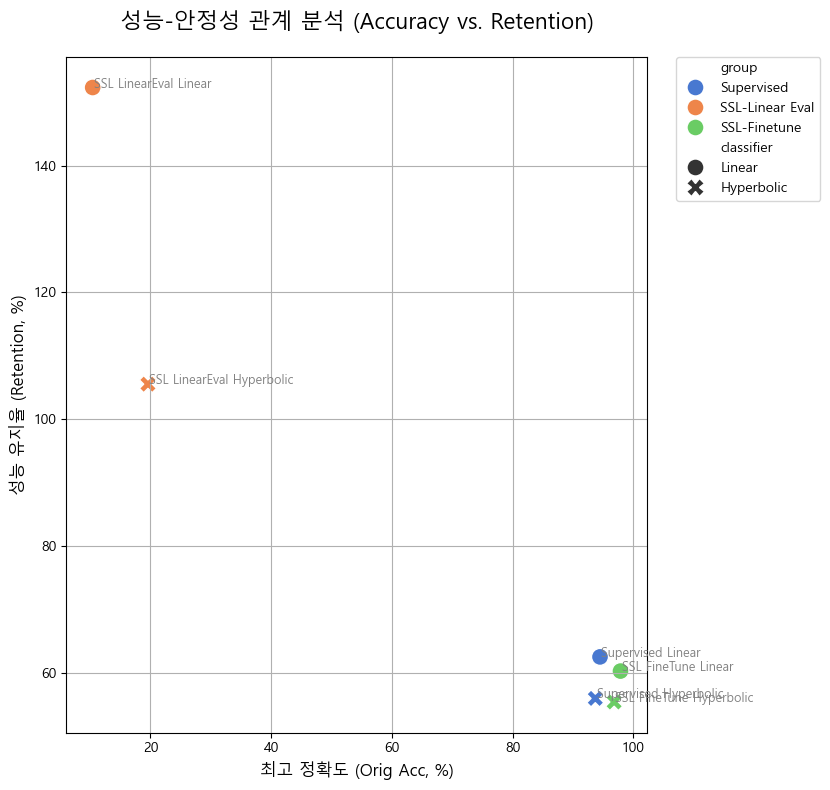


✅ 성능 하락 히트맵:


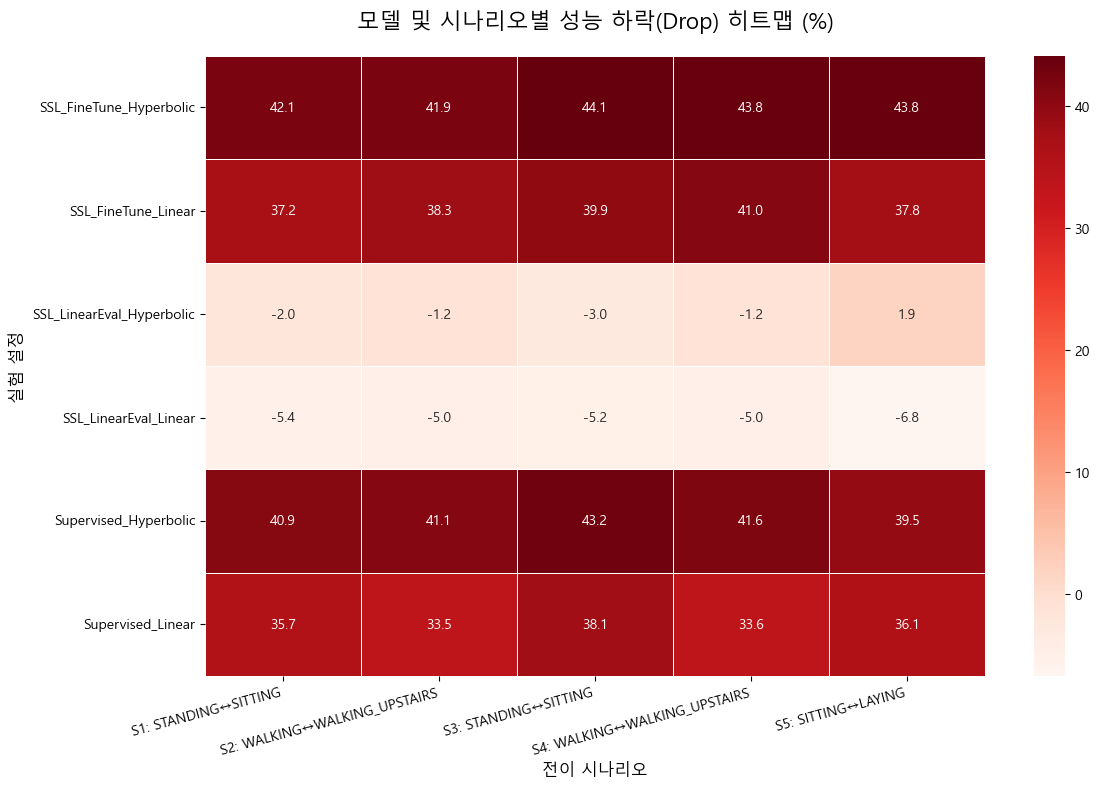


✅ 학습 방식별 안정성 분포 비교 그래프:


C:\Users\park9\AppData\Local\Temp\ipykernel_27260\1529842114.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='scenario_retention', data=scenario_df, palette='pastel')


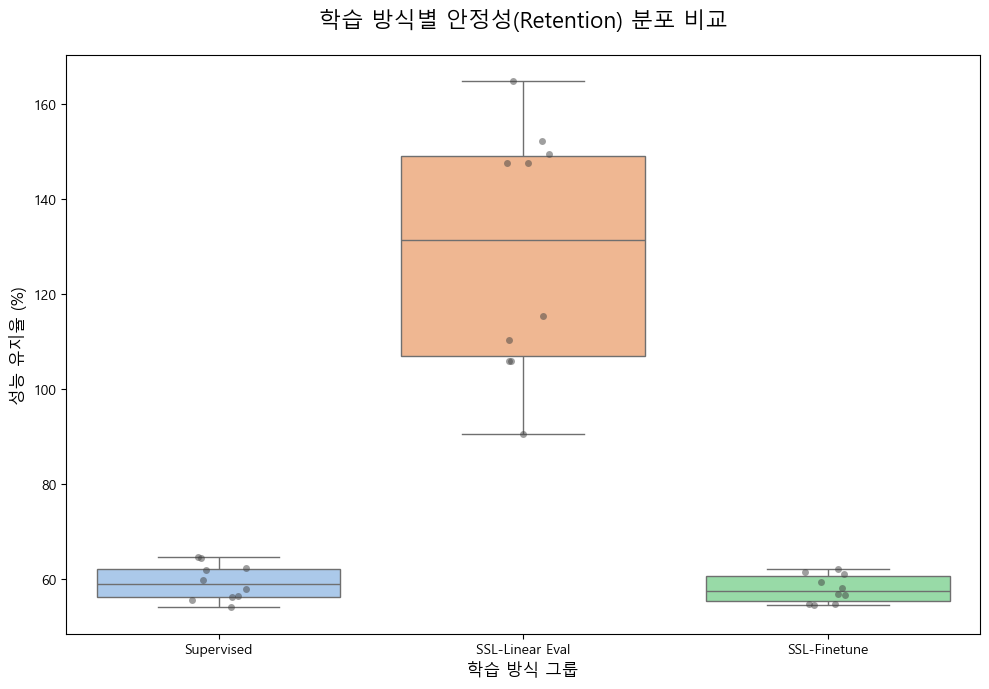


✅ 시나리오별 절대 성능(Accuracy) 상세 비교 그래프:


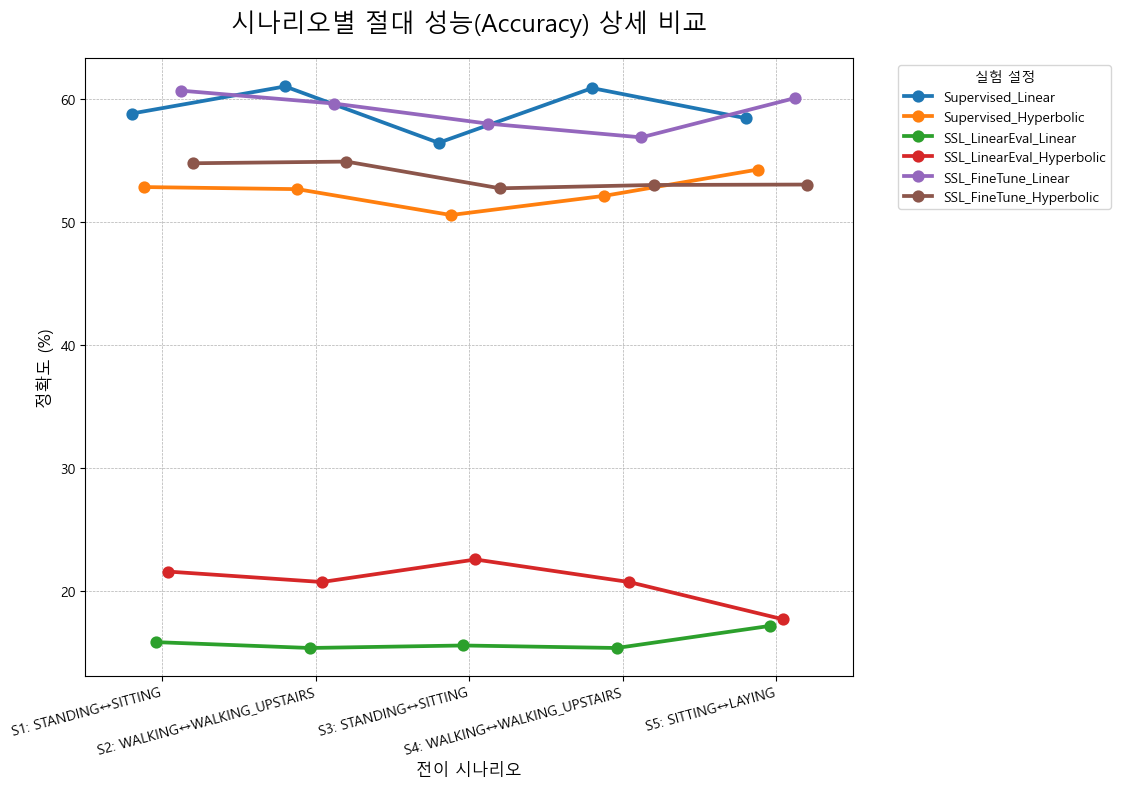


✅ 시나리오별 안정성(Retention) 상세 비교 그래프:


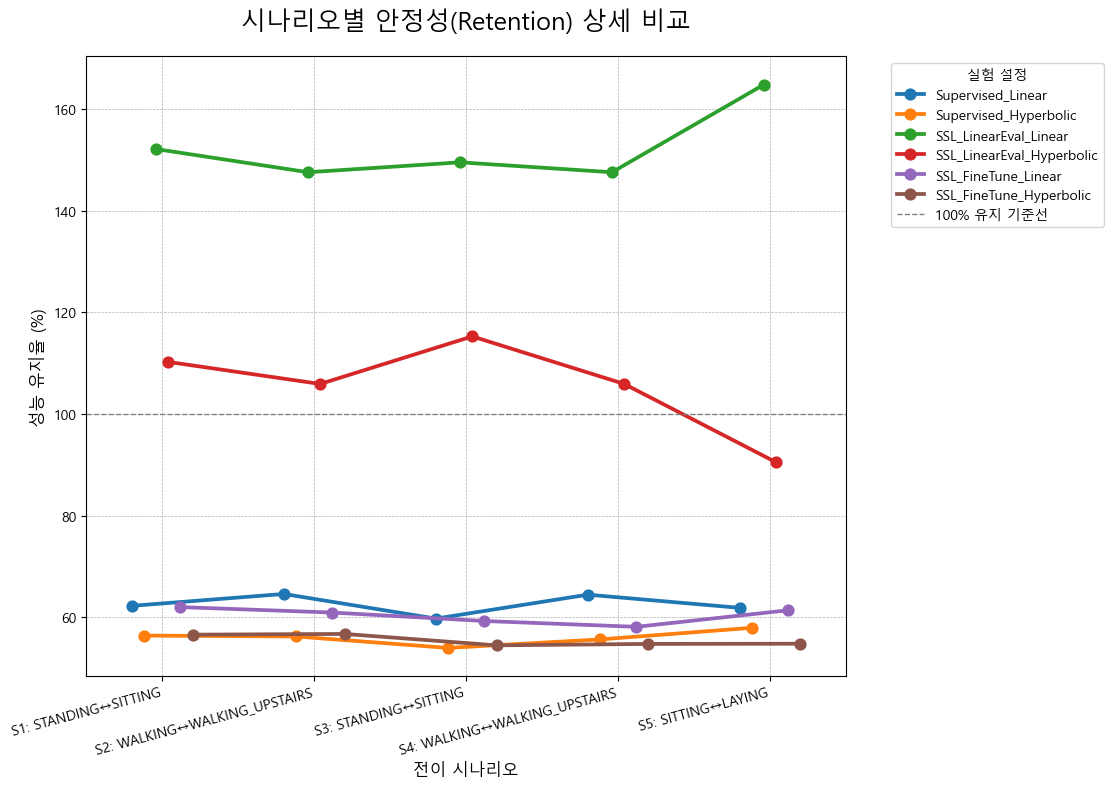


✅ 정확도 vs F1 스코어 관계도 그래프:


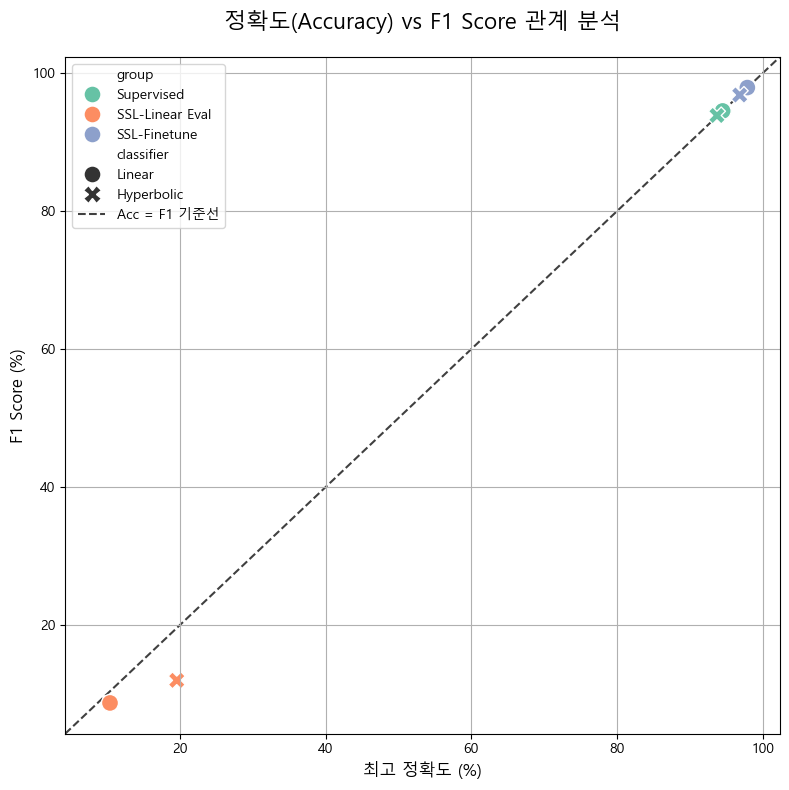


모든 시각화가 완료되었습니다.


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

def setup_korean_font():
    """
    한글 폰트를 설정합니다. Windows, Mac 환경에 맞게 폰트를 지정해주세요.
    """
    try:
        # Windows: 'Malgun Gothic', Mac: 'AppleGothic'
        plt.rcParams['font.family'] = 'Malgun Gothic'
    except RuntimeError:
        print("경고: 'Malgun Gothic' 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지

def load_and_process_data(json_path):
    """
    JSON 파일을 불러와 Pandas DataFrame으로 전처리합니다.
    메인 결과와 시나리오별 상세 결과를 별도의 DataFrame으로 반환합니다.
    """
    if not os.path.exists(json_path):
        print(f"오류: JSON 파일을 찾을 수 없습니다. 경로를 확인해주세요: {json_path}")
        return None, None

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    if not data:
        print("오류: JSON 파일이 비어있습니다.")
        return None, None

    # --- 메인 DataFrame 생성 ---
    df = pd.DataFrame(data)
    df['orig_acc_pct'] = df['orig_acc'] * 100
    df['orig_f1_pct'] = df.get('orig_f1', 0.0) * 100 # orig_f1이 없을 경우 대비
    df['group'] = df.apply(
        lambda row: f"SSL-{row['mode'].replace('_', ' ').title()}" if row['method'] == 'ssl' else 'Supervised',
        axis=1
    )
    df['config_readable'] = df['config'].str.replace('_', ' ')

    # --- 시나리오별 상세 DataFrame 생성 ---
    scenario_records = []
    for record in data:
        for scenario_result in record.get('transition_results', []):
            scenario_label = f"S{scenario_result.get('scenario', 'N/A')}"
            if 'class_A' in scenario_result and 'class_B' in scenario_result:
                 scenario_label += f": {scenario_result['class_A']}↔{scenario_result['class_B']}"

            new_record = {
                'config': record['config'],
                'group': df.loc[df['config'] == record['config'], 'group'].iloc[0],
                'scenario_label': scenario_label,
                'scenario_acc': scenario_result.get('class_acc', 0) * 100,
                'scenario_f1': scenario_result.get('class_f1', 0) * 100,
                'scenario_drop': scenario_result.get('class_drop', 0) * 100,
                'scenario_retention': (1 - scenario_result.get('class_drop', 0) / record['orig_acc']) * 100 if record.get('orig_acc', 0) > 0 else 0
            }
            scenario_records.append(new_record)
    
    scenario_df = pd.DataFrame(scenario_records)
    
    return df, scenario_df

def visualize_metric(df, metric_col, title, xlabel, is_pct=True):
    """지정된 평가지표를 비교하는 범용 막대그래프 함수"""
    df_sorted = df.sort_values(metric_col, ascending=False)
    
    plt.figure(figsize=(12, 7))
    barplot = sns.barplot(
        x=metric_col, y='config_readable', data=df_sorted,
        hue='group', palette='viridis', dodge=False
    )
    for p in barplot.patches:
        width = p.get_width()
        unit = '%' if is_pct else ''
        plt.text(width + 0.5, p.get_y() + p.get_height() / 2, f'{width:.2f}{unit}', va='center')
        
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('실험 설정', fontsize=12)
    
    max_val = df[metric_col].max() if not df[metric_col].empty else 110
    plt.xlim(0, max(110 if is_pct else max_val*1.1, max_val * 1.1))
    
    plt.legend(title='학습 방식')
    sns.despine(left=True, bottom=True)
    
    plt.tight_layout()
    print(f"\n✅ {title} 그래프:")
    plt.show()

def visualize_accuracy_vs_retention(df):
    """성능-안정성 관계도(Scatter Plot)를 생성하고 화면에 표시합니다."""
    plt.figure(figsize=(10, 8))
    scatterplot = sns.scatterplot(
        x='orig_acc_pct', y='retention', data=df,
        hue='group', style='classifier', s=150, palette='muted'
    )
    for i in range(df.shape[0]):
        plt.text(
            x=df.orig_acc_pct.iloc[i] + 0.2, y=df.retention.iloc[i],
            s=df.config_readable.iloc[i], fontdict=dict(color='gray', size=9)
        )
    plt.title('성능-안정성 관계 분석 (Accuracy vs. Retention)', fontsize=16, pad=20)
    plt.xlabel('최고 정확도 (Orig Acc, %)', fontsize=12)
    plt.ylabel('성능 유지율 (Retention, %)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    print("\n✅ 성능-안정성 관계도 그래프:")
    plt.show()

def visualize_drop_heatmap(scenario_df):
    """성능 하락(Drop) 히트맵을 생성하고 화면에 표시합니다."""
    if scenario_df.empty: return
    
    pivot_df = scenario_df.pivot_table(index='config', columns='scenario_label', values='scenario_drop')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="Reds", linewidths=.5)
    
    plt.title('모델 및 시나리오별 성능 하락(Drop) 히트맵 (%)', fontsize=16, pad=20)
    plt.xlabel('전이 시나리오', fontsize=12)
    plt.ylabel('실험 설정', fontsize=12)
    plt.xticks(rotation=15, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    print("\n✅ 성능 하락 히트맵:")
    plt.show()

def visualize_retention_distribution(scenario_df):
    """학습 방식별 안정성 분포를 박스 플롯으로 비교합니다."""
    if scenario_df.empty: return

    plt.figure(figsize=(10, 7))
    sns.boxplot(x='group', y='scenario_retention', data=scenario_df, palette='pastel')
    sns.stripplot(x='group', y='scenario_retention', data=scenario_df, color=".25", alpha=0.5)

    plt.title('학습 방식별 안정성(Retention) 분포 비교', fontsize=16, pad=20)
    plt.xlabel('학습 방식 그룹', fontsize=12)
    plt.ylabel('성능 유지율 (%)', fontsize=12)
    
    plt.tight_layout()
    print("\n✅ 학습 방식별 안정성 분포 비교 그래프:")
    plt.show()

def visualize_acc_vs_f1(df):
    """정확도(Accuracy) vs F1 스코어 관계도를 생성합니다."""
    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        x='orig_acc_pct', y='orig_f1_pct', data=df,
        hue='group', style='classifier', s=150, palette='Set2'
    )
    lims = [ np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()]) ]
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Acc = F1 기준선')
    plt.xlim(lims); plt.ylim(lims)
    
    plt.title('정확도(Accuracy) vs F1 Score 관계 분석', fontsize=16, pad=20)
    plt.xlabel('최고 정확도 (%)', fontsize=12)
    plt.ylabel('F1 Score (%)', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    print("\n✅ 정확도 vs F1 스코어 관계도 그래프:")
    plt.show()

def visualize_scenario_performance(scenario_df, metric, title, ylabel):
    """시나리오별 절대 성능(Accuracy) 또는 Retention 비교 그래프를 생성합니다."""
    if scenario_df.empty: return
    
    plt.figure(figsize=(14, 8))
    sns.pointplot(
        x='scenario_label', y=metric, hue='config',
        data=scenario_df, dodge=0.4, markers='o', linestyles='-'
    )
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('전이 시나리오', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=15, ha='right')
    if 'retention' in metric:
        plt.axhline(y=100, color='gray', linestyle='--', linewidth=1, label='100% 유지 기준선')
    plt.legend(title='실험 설정', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    print(f"\n✅ {title} 그래프:")
    plt.show()


def main():
    """
    메인 실행 함수
    """
    JSON_FILE_PATH = 'supervised_vs_ssl_results_optimized.json'
    
    setup_korean_font()
    main_df, scenario_df = load_and_process_data(JSON_FILE_PATH)
    
    if main_df is not None and not main_df.empty:
        # --- 시각화 실행 ---
        visualize_metric(main_df, 'orig_acc_pct', '실험별 최고 정확도(Original Accuracy) 비교', '최고 정확도 (%)')
        visualize_metric(main_df, 'retention', '실험별 안정성(Retention) 비교', '성능 유지율 (%)')
        visualize_metric(main_df, 'orig_f1_pct', '실험별 F1 Score 비교 (원본 데이터셋)', 'F1 Score (%)')
        visualize_accuracy_vs_retention(main_df)
        
        if scenario_df is not None and not scenario_df.empty:
            visualize_drop_heatmap(scenario_df)
            visualize_retention_distribution(scenario_df)
            visualize_scenario_performance(scenario_df, 'scenario_acc', '시나리오별 절대 성능(Accuracy) 상세 비교', '정확도 (%)')
            visualize_scenario_performance(scenario_df, 'scenario_retention', '시나리오별 안정성(Retention) 상세 비교', '성능 유지율 (%)')

        visualize_acc_vs_f1(main_df)

        print("\n모든 시각화가 완료되었습니다.")
    else:
        print("데이터프레임이 비어있어 시각화를 진행할 수 없습니다.")

if __name__ == '__main__':
    main()
